In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler

from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras import losses, optimizers

from awkde import GaussianKDE

/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [24]:
# Data
data_dir = '../data'

X_train = np.load(data_dir + '/unweighted_events/X_train_point_by_point_0.npy')
y_train = np.load(data_dir + '/unweighted_events/y_train_point_by_point_0.npy')

print(y_train)

X_calibration = np.load(data_dir + '/unweighted_events/X_calibration.npy')
weights_calibration = np.load(
    data_dir + '/unweighted_events/weights_calibration.npy')
    
# Scale data
scaler = StandardScaler()
scaler.fit(np.array(X_train, dtype=np.float64))
X_train_transformed = scaler.transform(X_train)
X_calibration_transformed = scaler.transform(X_calibration)

[0. 0. 0. ... 0. 0. 0.]


In [3]:
theta1 = 708
theta = 0

# Classifier

In [22]:
def loss_function_carl(y_true, y_pred):
    return losses.binary_crossentropy(y_true[:], y_pred[:])


def make_classifier(n_hidden_layers=3,
                    hidden_layer_size=100,
                    activation='tanh',
                    dropout_prob=0.0,
                    learn_log_r=False):
    # Inputs
    input_layer = Input(shape=(42,))

    # Network
    hidden_layer = Dense(hidden_layer_size, activation=activation)(input_layer)
    if n_hidden_layers > 1:
        hidden_layer_ = hidden_layers(n_hidden_layers - 1,
                                      hidden_layer_size=hidden_layer_size,
                                      activation=activation,
                                      dropout_prob=dropout_prob)
        hidden_layer = hidden_layer_(hidden_layer)

    if learn_log_r:
        log_r_hat_layer = Dense(1, activation='linear')(hidden_layer)
        r_hat_layer = Lambda(lambda x: K.exp(x))(log_r_hat_layer)
        s_hat_layer = Lambda(lambda x: 1./(1. + r_hat_layer))(log_r_hat_layer)

    else:
        s_hat_layer = Dense(1, activation='sigmoid')(hidden_layer)

    # Combine outputs
    model = Model(inputs=[input_layer], outputs=[s_hat_layer])

    # Compile model
    model.compile(loss=loss_function_carl,
                  optimizer=optimizers.Adam(clipnorm=1.))

    return model

In [23]:
# Train score regression
clf = KerasRegressor(lambda: make_classifier(n_hidden_layers=1),
                      epochs=3, verbose=1)

clf.fit(X_train_transformed, y_train)

Epoch 1/3
100000/100000 [==============================] - 4s 35us/step - loss: 0.0240
Epoch 2/3
100000/100000 [==============================] - 3s 34us/step - loss: 5.5894e-05
Epoch 3/3
100000/100000 [==============================] - 3s 33us/step - loss: 7.9407e-06


In [19]:
s_calibration = clf.predict(X_calibration_transformed)

19994/19994 [==============================] - 0s 10us/step


# Calibration

In [21]:
print(s_calibration)

[1.4295971e-06 5.3317553e-06 4.0513814e-06 ... 1.7953521e-06 1.4588571e-06
 3.7385357e-06]


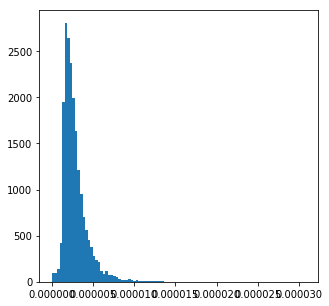

In [20]:
plt.figure(figsize=(5.,5.))
plt.hist(s_calibration, 100)
plt.show()

In [16]:
pdf_nom = GaussianKDE()
pdf_nom.fit(s_calibration, weights=weights_calibration[theta,::])

pdf_den = GaussianKDE()
pdf_den.fit(s_calibration, weights=weights_calibration[theta1,::])

NameError: name 's_calibration' is not defined

In [14]:
si = np.linspace(0.01, 1., 100).reshape((-1,1))

p_nom_eval = pdf_nom.predict(si)
p_den_eval = pdf_den.predict(si)
ratio_eval = p_nom_eval / p_den_eval

/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


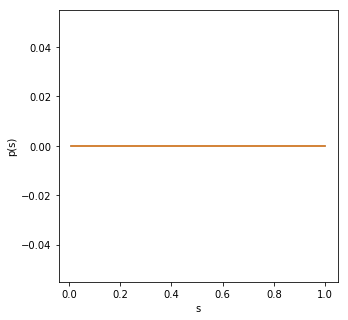

In [15]:
plt.figure(figsize=(5.,5.))

plt.plot(si,p_nom_eval, label='nom')
plt.plot(si,p_den_eval, label='den')
plt.xlabel('s')
plt.ylabel('p(s)')

plt.show()